# Import libraries

In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Reshape, Concatenate, Dot

import math
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects


Using TensorFlow backend.


# Load Dataset

In [2]:
def load_dataset(dataset_id = 1):
    filename_train = '../data/train/u'+str(dataset_id)+'.base'
    filename_test = '../data/train/u'+str(dataset_id)+'.test'
    dataset_train_df = pd.read_csv(filename_train, names=['user_id','movie_id','rating','time_stamp'], header=None, delimiter='\t')
    dataset_test_df = pd.read_csv(filename_test, names=['user_id','movie_id','rating','time_stamp'], header=None, delimiter='\t')
    # dataset = dataset_df.to_dict('records')
    return dataset_train_df, dataset_test_df  
   

In [3]:
def one_hot_encoding(labels):
    encodeds = [
        [1., .0, .0, .0, .0],
        [.0, 1., .0, .0, .0],
        [.0, .0, 1., .0, .0],
        [.0, .0, .0, 1., .0],
        [.0, .0, .0, .0, 1.],
    ]
    labels_encoded = np.array([encodeds[int(label)-1] for label in labels])
    return labels_encoded

In [4]:
def one_hot_encoding_smoothing(labels):
    encodeds = [
        [.75, .25, .0, .0, .0],
        [.15, .7, .15, .0, .0],
        [.0, .15, .7, .15, .0],
        [.0, .0, .15, .7, .15],
        [.0, .0, .0, .25, .75],
    ]
    labels_encoded = np.array([encodeds[int(label)-1] for label in labels])
    return labels_encoded

In [5]:
dataset_train_df, dataset_test_df = load_dataset(dataset_id=1)

train_x_user = dataset_train_df['user_id'].values
train_x_item = dataset_train_df['movie_id'].values
train_y = dataset_train_df['rating'].values
train_y_encoded = one_hot_encoding(train_y)
train_y_encoded_smoothing = one_hot_encoding_smoothing(train_y)

test_x_user = dataset_test_df['user_id'].values
test_x_item = dataset_test_df['movie_id'].values
test_y = dataset_test_df['rating'].values
test_y_encoded = one_hot_encoding(test_y)
test_y_encoded_smoothing = one_hot_encoding_smoothing(test_y)

num_of_users = dataset_train_df['user_id'].max() + 1
num_of_items = dataset_train_df['movie_id'].max() + 1
num_of_factors = 100

# Scatter results

In [6]:
# Define our own plot function
def scatter(y, pred_y, subtitle='result.png'):
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    
    
    sc = ax.scatter(y, pred_y, lw=0, s=40)
    plt.xlim(-2, 7)
    plt.ylim(-2, 7)
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)
    

# Make CFModel (Collaborative-Filtering Model)

### 1) model #1 - embedded vector

##### - build model

In [7]:
class CFModel(Model):
    def __init__(self, num_of_users, num_of_items, num_of_factors):
        # input_user_id
        model_Embedding_user_id = Sequential([
            Embedding(num_of_users, num_of_factors, input_length=1, input_shape=(1,)),
            Reshape((num_of_factors,)),
        ])
        # input_item_id
        model_Embedding_item_id = Sequential([
            Embedding(num_of_items, num_of_factors, input_length=1, input_shape=(1,)),
            Reshape((num_of_factors,))
        ])
    
        # create base network
        input_user_id = Input((1,), name='input_user_id')
        input_item_id = Input((1,), name='input_item_id')
        embedded_user_id = model_Embedding_user_id(input_user_id)
        embedded_item_id = model_Embedding_item_id(input_item_id)
    
        output_label = Dot(axes=1)([embedded_user_id, embedded_item_id])
        
        super(CFModel, self).__init__(
            inputs=[input_user_id, input_item_id], 
            outputs=output_label
        )
        
    def score(self, y, pred_y):
        return np.sqrt( np.sum(np.square(pred_y.reshape(-1, 1) - y.reshape(-1,1))) / len(y) )
    

In [8]:
model = CFModel(num_of_users, num_of_items, num_of_factors)
model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(),
)
model.summary()

Model: "cf_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_user_id (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_item_id (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 100)          94400       input_user_id[0][0]              
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 100)          168300      input_item_id[0][0]              
___________________________________________________________________________________________

##### - train model

In [9]:
callbacks = [
    tf.keras.callbacks.EarlyStopping('val_loss', patience=5),
]
result = model.fit(
    [train_x_user, train_x_item], train_y,
    batch_size = 512,
    epochs = 1000,
    shuffle = True,
    verbose = True,
    validation_data = ([test_x_user, test_x_item], test_y),
    callbacks = callbacks,
)

model.save_weights('weights_CF.h5')

Train on 80000 samples, validate on 20000 samples
Epoch 1/1000
80000/80000 [==============================] - 2s 26us/sample - loss: 13.6099 - val_loss: 13.3095
Epoch 2/1000
80000/80000 [==============================] - 1s 10us/sample - loss: 8.4357 - val_loss: 3.6623
Epoch 3/1000
80000/80000 [==============================] - 1s 10us/sample - loss: 1.7424 - val_loss: 1.3898
Epoch 4/1000
80000/80000 [==============================] - 1s 10us/sample - loss: 1.0542 - val_loss: 1.0815
Epoch 5/1000
80000/80000 [==============================] - 1s 10us/sample - loss: 0.9226 - val_loss: 0.9913
Epoch 6/1000
80000/80000 [==============================] - 1s 11us/sample - loss: 0.8732 - val_loss: 0.9533
Epoch 7/1000
80000/80000 [==============================] - 1s 10us/sample - loss: 0.8436 - val_loss: 0.9321
Epoch 8/1000
80000/80000 [==============================] - 1s 10us/sample - loss: 0.8220 - val_loss: 0.9166
Epoch 9/1000
80000/80000 [==============================] - 1s 10us/sample -

##### - get results

RMSE :  0.9325827305846177


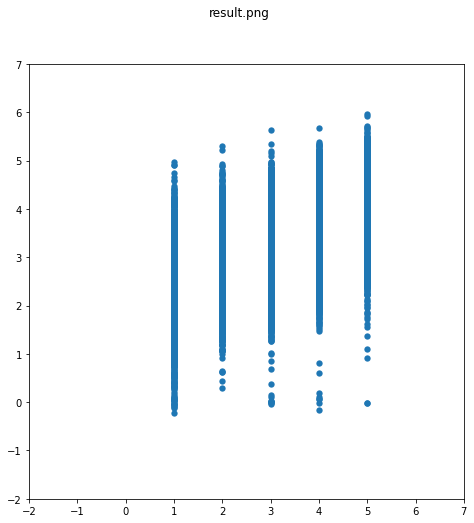

In [10]:
pred_y = model.predict([test_x_user, test_x_item]).reshape(-1,1)

print('RMSE : ', model.score(test_y, pred_y))
scatter(test_y, pred_y)

### 2) model #2 - DNN with label encoding

##### - build model

In [22]:
class DNNModel_label(Model):
    def __init__(self, num_of_users, num_of_items, num_of_factors):
        
        # tensor_0 : input
        input_user_id = Input((1,), name='input_user_id')
        input_item_id = Input((1,), name='input_item_id')
        
        # model_0 : embedding inpput
        model_Embedding_user_id = Sequential([
            Embedding(num_of_users, num_of_factors, input_length=1, input_shape=(1,)),
            Reshape((num_of_factors,)),
        ])
        model_Embedding_item_id = Sequential([
            Embedding(num_of_items, num_of_factors, input_length=1, input_shape=(1,)),
            Reshape((num_of_factors,)),
        ])
        
        # tensor_1 : embedded input
        embedded_user_id = model_Embedding_user_id(input_user_id)
        embedded_item_id = model_Embedding_item_id(input_item_id)
        
        # tensor_2 : embedded vector
        embedded_vector = Concatenate(axis=-1)([embedded_user_id, embedded_item_id])
        
        # model_2 : DNN
        p_dropout=0.1
        model_DNN = Sequential([
            Dropout(p_dropout),
            Dense(num_of_factors * 2, activation='relu'),
            Dropout(p_dropout),
            Dense(20, activation='relu'),
            Dropout(p_dropout),
            Dense(1, activation='linear')
        ])    
        
        # tensor_3 : output_label
        output_label = model_DNN(embedded_vector)
        
        super(DNNModel_label, self).__init__(
            inputs=[input_user_id, input_item_id], 
            outputs=output_label
        )
    
    def score(self, y, pred_y):
        return np.sqrt( np.sum(np.square(pred_y.reshape(-1, 1) - y.reshape(-1,1))) / len(y) )
        

In [23]:
model = DNNModel_label(num_of_users, num_of_items, num_of_factors)
model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(),
)
model.summary()

Model: "dnn_model_label_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_user_id (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_item_id (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 100)          94400       input_user_id[0][0]              
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 100)          168300      input_item_id[0][0]              
__________________________________________________________________________________

##### - train model

In [24]:
callbacks = [
    tf.keras.callbacks.EarlyStopping('val_loss', patience=5),
]
result = model.fit(
    [train_x_user, train_x_item], train_y,
    batch_size = 512,
    epochs = 1000,
    shuffle = True,
    verbose = True,
    validation_data = ([test_x_user, test_x_item], test_y),
    callbacks = callbacks,
)

model.save_weights('weights_DNN_label.h5')

Train on 80000 samples, validate on 20000 samples
Epoch 1/1000
80000/80000 [==============================] - 2s 22us/sample - loss: 2.8631 - val_loss: 0.9651
Epoch 2/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 1.0567 - val_loss: 0.9448
Epoch 3/1000
80000/80000 [==============================] - 1s 11us/sample - loss: 1.0235 - val_loss: 0.9260
Epoch 4/1000
80000/80000 [==============================] - 1s 11us/sample - loss: 0.9953 - val_loss: 0.9189
Epoch 5/1000
80000/80000 [==============================] - 1s 11us/sample - loss: 0.9827 - val_loss: 0.9264
Epoch 6/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.9682 - val_loss: 0.9043
Epoch 7/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.9539 - val_loss: 0.8937
Epoch 8/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.9299 - val_loss: 0.8916
Epoch 9/1000
80000/80000 [==============================] - 1s 12us/sample - l

##### - get results

RMSE :  0.9534538186515148


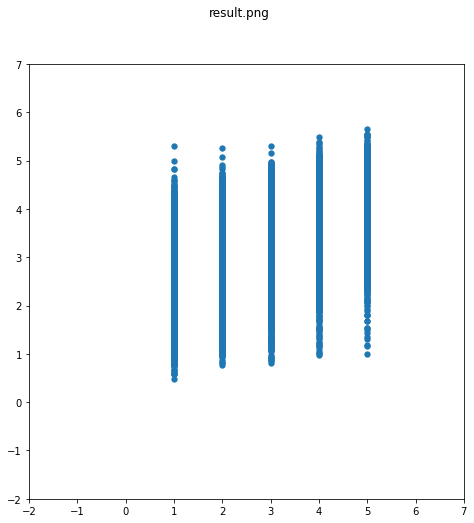

In [25]:
pred_y = model.predict([test_x_user, test_x_item]).reshape(-1,1)

print('RMSE : ', model.score(test_y, pred_y))
scatter(test_y, pred_y)

### 3) model #3 - DNN with one-hot encoding

##### - build model

In [15]:
class DNNModel_onehot(Model):
    def __init__(self, num_of_users, num_of_items, num_of_factors):
        
        # tensor_0 : input
        input_user_id = Input((1,), name='input_user_id')
        input_item_id = Input((1,), name='input_item_id')
        
        # model_0 : embedding inpput
        model_Embedding_user_id = Sequential([
            Embedding(num_of_users, num_of_factors, input_length=1, input_shape=(1,)),
            Reshape((num_of_factors,)),
        ])
        model_Embedding_item_id = Sequential([
            Embedding(num_of_items, num_of_factors, input_length=1, input_shape=(1,)),
            Reshape((num_of_factors,)),
        ])
        
        # tensor_1 : embedded input
        embedded_user_id = model_Embedding_user_id(input_user_id)
        embedded_item_id = model_Embedding_item_id(input_item_id)
        
        # tensor_2 : embedded vector
        embedded_vector = Concatenate(axis=-1)([embedded_user_id, embedded_item_id])
        
        # model_2 : DNN
        p_dropout=0.1
        model_DNN = Sequential([
            Dropout(p_dropout),
            Dense(num_of_factors * 2, activation='relu'),
            Dropout(p_dropout),
            Dense(5, activation='softmax'),
        ])    
        
        # tensor_3 : output_label
        output_label = model_DNN(embedded_vector)
        
        super(DNNModel_onehot, self).__init__(
            inputs=[input_user_id, input_item_id], 
            outputs=output_label
        )

    def score(self, y, pred_y):
        return np.sqrt( np.sum(np.square(pred_y.reshape(-1, 1) - y.reshape(-1,1))) / len(y) )
        

### - train model and get results

##### 3_a) one-hot encoding

In [16]:
model = DNNModel_onehot(num_of_users, num_of_items, num_of_factors)
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
)
#model.summary()

In [17]:
callbacks = [
    tf.keras.callbacks.EarlyStopping('val_loss', patience=5),
]
result = model.fit(
    [train_x_user, train_x_item], train_y_encoded,
    batch_size = 512,
    epochs = 1000,
    shuffle = True,
    verbose = True,
    validation_data = ([test_x_user, test_x_item], test_y_encoded),
    callbacks = callbacks,
)

model.save_weights('weights_DNN_onehot.h5')

Train on 80000 samples, validate on 20000 samples
Epoch 1/1000
80000/80000 [==============================] - 2s 23us/sample - loss: 0.4403 - val_loss: 0.4151
Epoch 2/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.4055 - val_loss: 0.4106
Epoch 3/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.3986 - val_loss: 0.4096
Epoch 4/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.3935 - val_loss: 0.4095
Epoch 5/1000
80000/80000 [==============================] - 1s 13us/sample - loss: 0.3895 - val_loss: 0.4096
Epoch 6/1000
80000/80000 [==============================] - 1s 13us/sample - loss: 0.3859 - val_loss: 0.4109
Epoch 7/1000
80000/80000 [==============================] - 1s 14us/sample - loss: 0.3824 - val_loss: 0.4124
Epoch 8/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.3791 - val_loss: 0.4124
Epoch 9/1000
80000/80000 [==============================] - 1s 12us/sample - l

RMSE :  1.3464026143765466


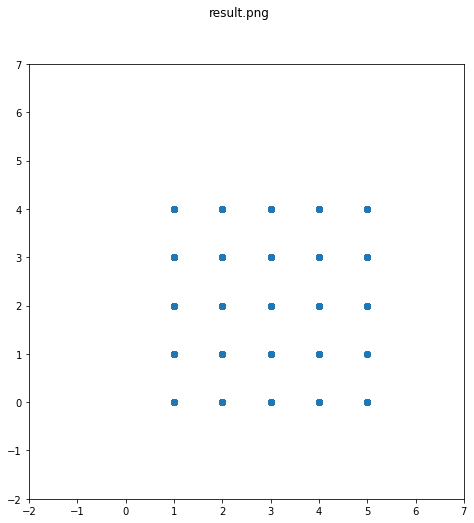

In [18]:
pred_y_encoded = model.predict([test_x_user, test_x_item]).reshape(-1,1)
pred_y = pred_y_encoded.reshape(-1,5,).argmax(axis=1)

print('RMSE : ', model.score(test_y, pred_y))
scatter(test_y, pred_y)

##### 3_b) one-hot encoding with smoothing

In [19]:
model = DNNModel_onehot(num_of_users, num_of_items, num_of_factors)
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
)
#model.summary()

In [20]:
callbacks = [
    tf.keras.callbacks.EarlyStopping('val_loss', patience=5),
]
result = model.fit(
    [train_x_user, train_x_item], train_y_encoded_smoothing,
    batch_size = 512,
    epochs = 1000,
    shuffle = True,
    verbose = True,
    validation_data = ([test_x_user, test_x_item], test_y_encoded_smoothing),
    callbacks = callbacks,
)

model.save_weights('weights_DNN_onehot_smoothing.h5')

Train on 80000 samples, validate on 20000 samples
Epoch 1/1000
80000/80000 [==============================] - 2s 21us/sample - loss: 0.4516 - val_loss: 0.4354
Epoch 2/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.4315 - val_loss: 0.4329
Epoch 3/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.4280 - val_loss: 0.4318
Epoch 4/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.4254 - val_loss: 0.4314
Epoch 5/1000
80000/80000 [==============================] - 1s 11us/sample - loss: 0.4233 - val_loss: 0.4315
Epoch 6/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.4214 - val_loss: 0.4313
Epoch 7/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.4196 - val_loss: 0.4315
Epoch 8/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.4178 - val_loss: 0.4313
Epoch 9/1000
80000/80000 [==============================] - 1s 12us/sample - l

RMSE :  1.3415103428598678


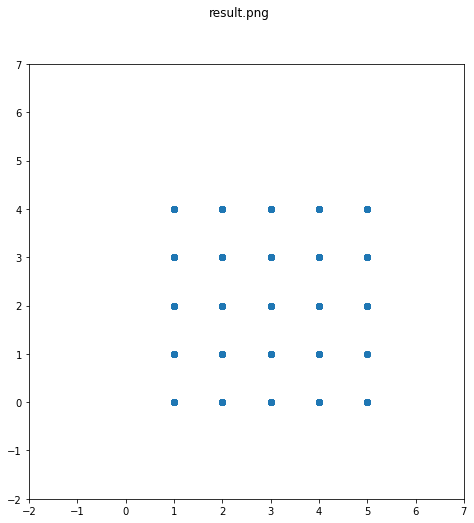

In [21]:
pred_y_encoded = model.predict([test_x_user, test_x_item]).reshape(-1,1)
pred_y = pred_y_encoded.reshape(-1,5,).argmax(axis=1)

print('RMSE : ', model.score(test_y, pred_y))
scatter(test_y, pred_y)